# **Time Series Analysis w/ Moving Averages and a LSTM Network**

Predicting the *change in demand-, the change in climate-, the change in energy usage-, the change in traffic-* over the course of a *day, week, month, or year*, are all non-trivial matters. To answer any of these matters, one must consider **Time Series Analysis**. A ***Time-Series*** is a series of data observations that are indexed with a measure of time. ***Time Series Analysis*** consists of using various methods for analyzing the Time Series data, and extracting any meaningful statistics, patterns, and other characteristics, which might be inherent in the data. ***Time Series Forecasting*** is the use of a model to predict future observations on the basis of previously observed values. 

***Scope:*** In this project, we perform some basic time series analysis using Moving Averages and Exponential Smoothing on the SPY ETF data collected over the course of 1993 - 2020. We also employ a RNN to perform Time Series Forecasting. 

# **Import Libraries and SetUp**

In [0]:
# Import Basic
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Import ML and DL Libraries
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
path = "/content/gdrive/My Drive/Stock Data/SPY.csv"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
def mse(ypred, yact): return ((ypred-yact)**2).mean()

In [0]:
def mseperct(ypred, yact): return ((np.abs(ypred - yact)/yact) / yact).mean() * 100

In [0]:
def predaccuracy(ypred, yact): return (ypred/yact) * 100

In [0]:
def trendaccuracy(ypred, yact):
  t = 0; j = 0

  for i in range(1, len(ypred), 1):
    if np.sign(ypred[i] - ypred[i-1]) == np.sign(yact[i] - yact[i - 1]):
      t += 1
    j += 1
  return (t / j) * 100

In [0]:
def downtrendaccuracy(ypred, yact):
  t = 0; j = 0;

  for i in range(1, len(ypred), 1):
    if (np.sign(yact[i] - yact[i - 1]) == -1 ):
      j += 1
      if (np.sign(ypred[i] - ypred[i-1]) == -1):
        t += 1
  return ((t / j) * 100), j

In [0]:
def uptrendaccuracy(ypred, yact):
  t = 0; j = 0;

  for i in range(1, len(ypred), 1):
    if (np.sign(yact[i] - yact[i - 1]) == 1 ):
      j += 1
      if (np.sign(ypred[i] - ypred[i-1]) == 1):
        t += 1
  return ((t / j) * 100), j

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
%matplotlib inline
font = {'family':'normal', 'weight':'bold','size':16}
matplotlib.rc('font', **font)
color = 'black'
matplotlib.rcParams['text.color'] = color
matplotlib.rcParams['axes.labelcolor'] = color
matplotlib.rcParams['xtick.color'] = color
matplotlib.rcParams['ytick.color'] = color

# **Import Data**
Below we see that we have several features in this Time-Series data. We aren't concerned with the Adjusted Close or Volume, so we will drop these columns. Moving forward, we will also use the ***average of the open price and the close price*** as a representative of the ETF price for the given day. 

In [11]:
data = pd.read_csv(path, index_col = ['Date'], parse_dates=['Date'])
data.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.96875,43.96875,43.75000,43.93750,26.299288,1003200
1993-02-01,43.96875,44.25000,43.96875,44.25000,26.486324,480500
1993-02-02,44.21875,44.37500,44.12500,44.34375,26.542448,201300
1993-02-03,44.40625,44.84375,44.37500,44.81250,26.822998,529400
1993-02-04,44.96875,45.09375,44.46875,45.00000,26.935240,531500
1993-02-05,44.96875,45.06250,44.71875,44.96875,26.916538,492100
1993-02-08,44.96875,45.12500,44.90625,44.96875,26.916538,596100
1993-02-09,44.81250,44.81250,44.56250,44.65625,26.729490,122100
1993-02-10,44.65625,44.75000,44.53125,44.71875,26.766899,379600


In [12]:
drop = ['Adj Close', 'Volume']
data.drop(drop, axis = 1, inplace=True)
data.head(5)

,Open,High,Low,Close
Date,,,,
1993-01-29,43.96875,43.96875,43.75000,43.93750
1993-02-01,43.96875,44.25000,43.96875,44.25000
1993-02-02,44.21875,44.37500,44.12500,44.34375
1993-02-03,44.40625,44.84375,44.37500,44.81250
1993-02-04,44.96875,45.09375,44.46875,45.00000


In [13]:
data['Average'] =  data[['Open', 'Close']].mean(axis=1)
data.head(5)

,Open,High,Low,Close,Average
Date,,,,,
1993-01-29,43.96875,43.96875,43.75000,43.93750,43.953125
1993-02-01,43.96875,44.25000,43.96875,44.25000,44.109375
1993-02-02,44.21875,44.37500,44.12500,44.34375,44.281250
1993-02-03,44.40625,44.84375,44.37500,44.81250,44.609375
1993-02-04,44.96875,45.09375,44.46875,45.00000,44.984375


# **Lets First Look at the Data**

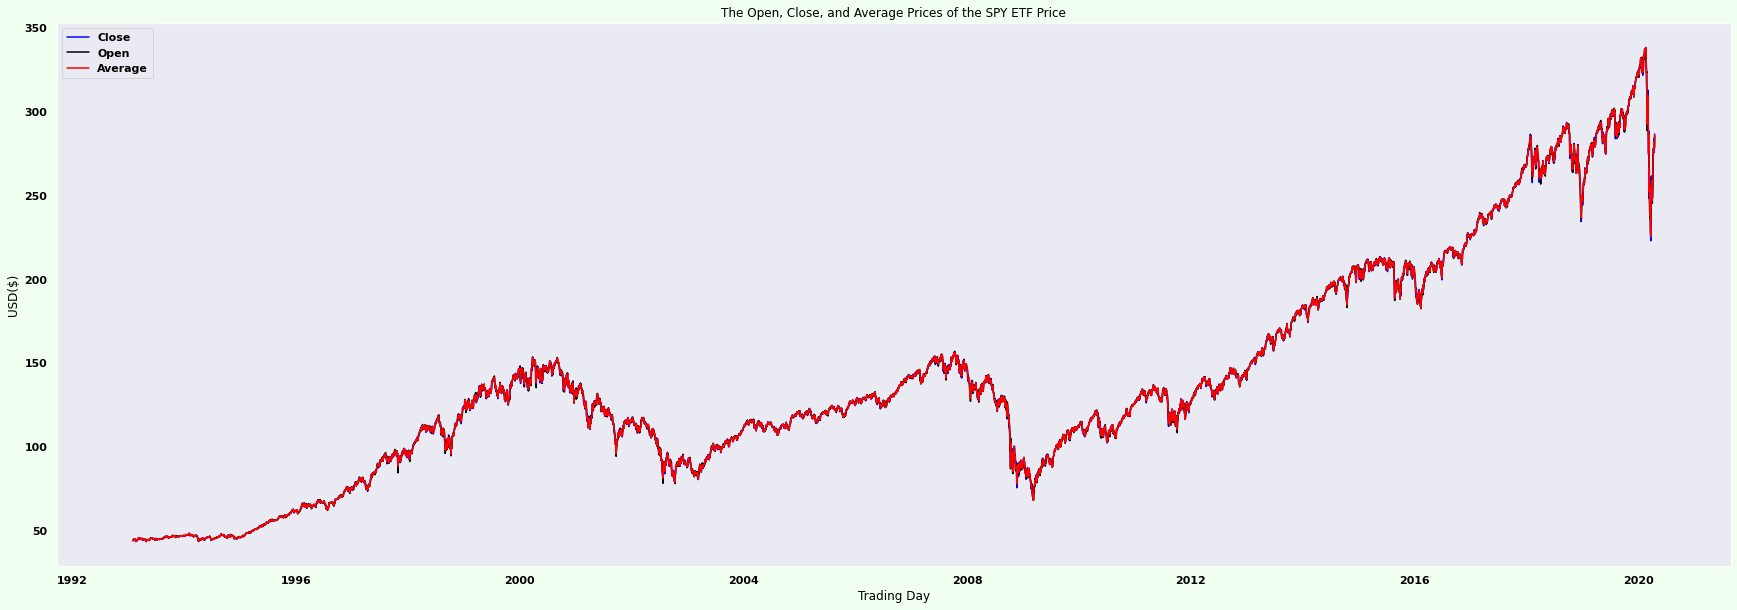

In [27]:
fig = plt.figure(figsize=(30,10), facecolor = 'honeydew')
ax = fig.add_subplot(1,1,1)
ax.plot(data.Close, c = "blue")
ax.plot(data.Open, c = "black")
ax.plot(data.Average, c = "red")
ax.set_title("The Open, Close, and Average Prices of the SPY ETF Price")
ax.set(xlabel = "Trading Day", ylabel = "USD($)")
ax.legend(("Close", "Open", "Average"), loc = 'upper left')
ax.grid(False)
plt.show()

Looking at the plot above, we can see that the 'Average' of the open and close prices is a good representation of the ETF price for the day. Moving forward, we will work with the 'Average' price.

# **Let's Get to the Moving Average**

The moving-average, or rather moving-averages, are sucessive average calculated over successive segments of the dataset--the segments are of constant size, which here we refer to as "Windows"

In [0]:
def plt_ma(data, winsize, plt_int = False, scale = 1.96):
  roll_mean = data.rolling(window = winsize).mean()

  fig = plt.figure(figsize=(30,10), facecolor = 'honeydew')
  ax = fig.add_subplot(1,1,1)
  ax.set_title("Moving Aveage, Window Size = {}.".format(winsize))
  ax.plot(roll_mean, c = 'blue', label = "Moving Average")
  ax.plot(data[winsize:], c = 'black', label = "Actual Price")

  if plt_int:
    mae = mean_absolute_error(data[winsize:], roll_mean[winsize:])
    dev = np.std(data[winsize:] - roll_mean[winsize:])
    lb = roll_mean - (mae + scale*dev)
    ub = roll_mean + (mae + scale*dev)
    ax.plot(lb, 'r--', label = "Upper/Lowe Bounds")
    ax.plot(ub, 'r--')
  
  ax.set(xlabel = "Trading Day", ylabel = "USD ($)")
  ax.legend(loc = "best")
  ax.grid(False)
  plt.show()

## **30-Day Moving Average**

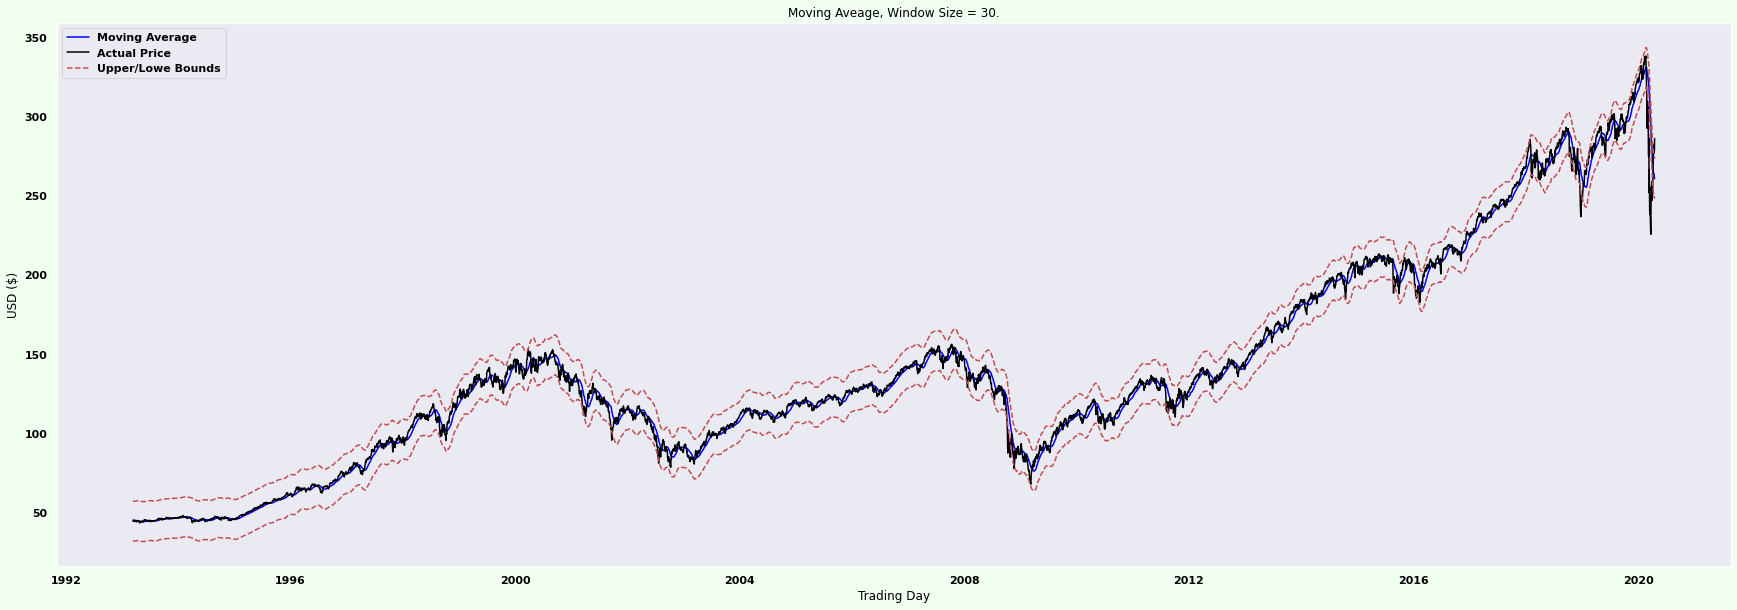

In [39]:
plt_ma(data.Average, 30, plt_int=True)

## **90-Day Moving Average**

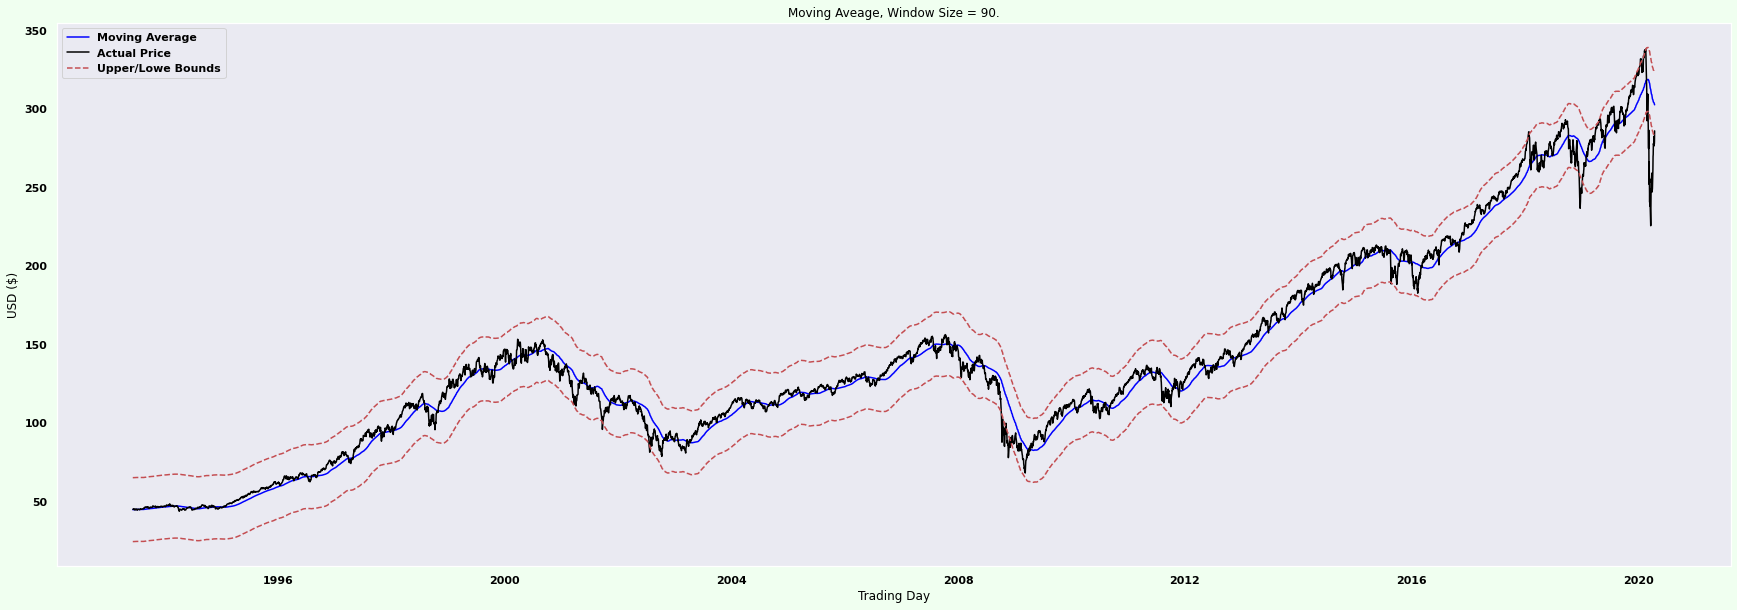

In [40]:
plt_ma(data.Average, 90, plt_int=True)

## **Some Observations**
We notice that as we increase the Window Size, the average gets smoother--meaning it does not fit every valley and hill of the actual price plot. Its evident that the **Moving Averages** are not consistent over-time--***which suggests that this time series is not stationary***. In this project, we proceed as if the series was stationary. 

# **Let's Look Exponential Smoothing**

**Exponential Smoothing** involves smoothing the time-series data using an exponential window function, which considers the 'error' of the previous prediction(s).

The Exponential Smoothing function: **F(t + 1) = F(t) + α(Y(t) - F(t))**
> Where:
>> * F represents the forecast
>> * Y represents the actual value
>> * α represents the alpa-value--which is a value between 0 and 1

The function can be reaggranged to the followin: **F(t + 1) = αY(t) + (1 - α)F(t)**

In [0]:
def expsmoothing (data, alpha):
  results = [data[0]]
  for i in range(1, len(data), 1):
    exp = results[i - 1] + alpha*(data[i] - results[i-1])
    results.append(exp)
  return results

def plt_exp(data, alphas):
  fig = plt.figure(figsize=(30,10), facecolor = 'honeydew')
  ax = fig.add_subplot(1,1,1)
  ax.plot(data.values, c = 'blue', label = "Actual")
  for a in alphas:
      ax.plot(expsmoothing(data, a), label = "Alpha = {}".format(a))
  ax.set_title("Exponential Smoothing")
  ax.set(xlabel = "Trading Day", ylabel ="USD ($)")
  #plt.axis('tight')
  ax.legend(loc = "best")
  ax.grid(False)
  plt.show()

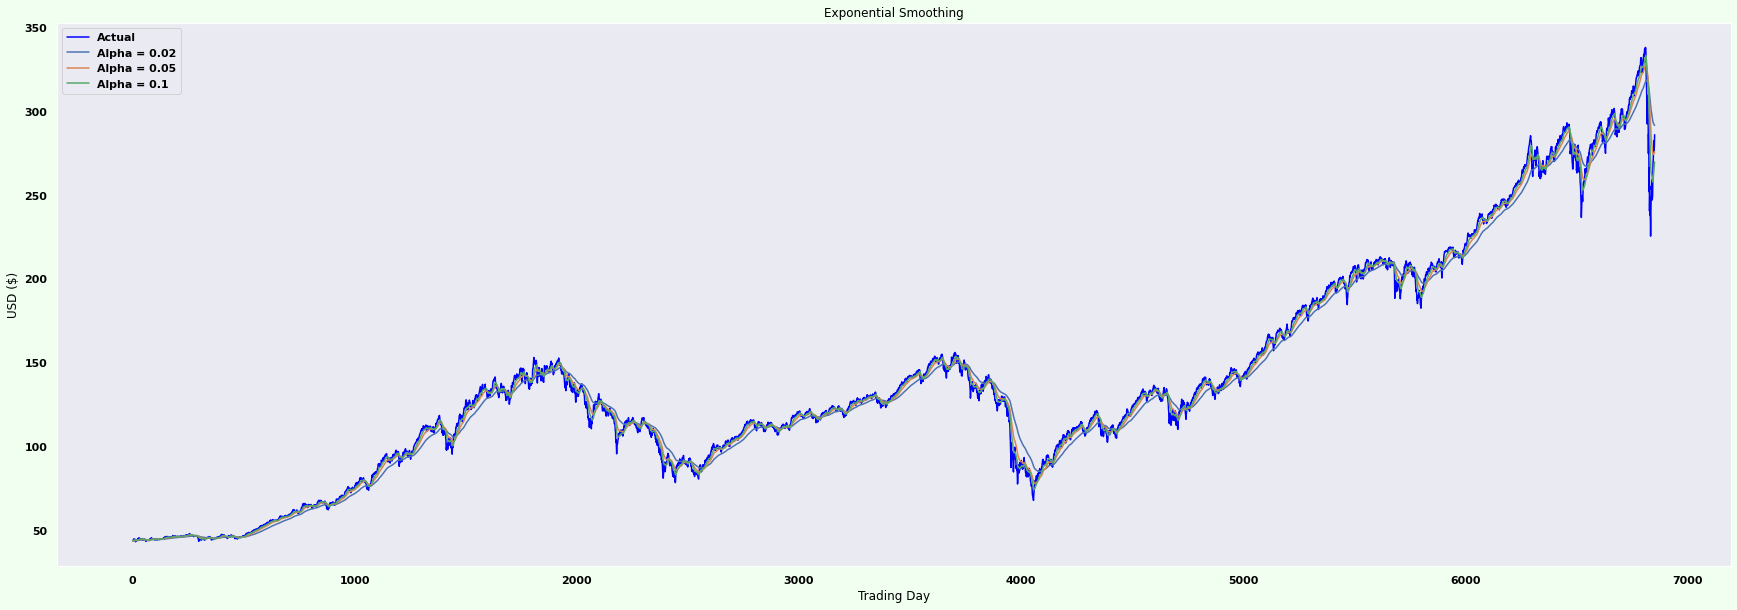

In [44]:
plt_exp(data.Average, [.02, .05, .1])

## **Some Observations**
We see that with a higher  alpha value, the exponential smoothing average fits the time-series data more closely. Decreasing the *alpha value* has a similar effect to increasing the *window size* in the Moving Average plot.

# **Let's Look at Double Exponential Smoothing**

Double Exponential Smoothing is used when there is a trend in the time-series. In this time series, we do have a general upwards trend.
The equations are as follows. 

1. **L(t) = aY(t) + (1 - a)(L(t - 1) + T(t - 1))**
2. **T(t) = b(L(t) - L(t - 1)) + (1 - b)T(t -1)**
3. **Y(t) = L(t - 1) + T(t - 1)**


In [0]:
def double_expsmoothing(data, alpha, beta):
  results = [data[0]]
  for i in range(1, len(data) + 1, 1):
    if i == 1:
      l, t = data[0], data[1] - data[0]
    if i >= len(data):
      y = results[-1]
    else:
      y = data[i]
    ll, l = l, alpha * y + (1 - alpha) * (l + t)
    t = beta * (l - ll) + (1 - beta) * t
    exp = l + t;
    results.append(exp)
  return results

def plt_dexp(data, alphas, betas):
  fig = plt.figure(figsize=(30,10), facecolor = 'honeydew')
  ax = fig.add_subplot(1,1,1)
  ax.plot(data.values, c = "blue", label = "Actual Prices")
  for a in alphas:
    for b in betas:
      ax.plot(double_expsmoothing(data, a, b), label = "Alpha = {}\nBeta = {}".format(a, b))
  ax.set_title("Double Exponential Smoothing")
  ax.set(xlabel = "Trading Day", ylabel = "USD ($)")
  ax.legend(loc = "best")
  ax.grid(False)
  plt.show()

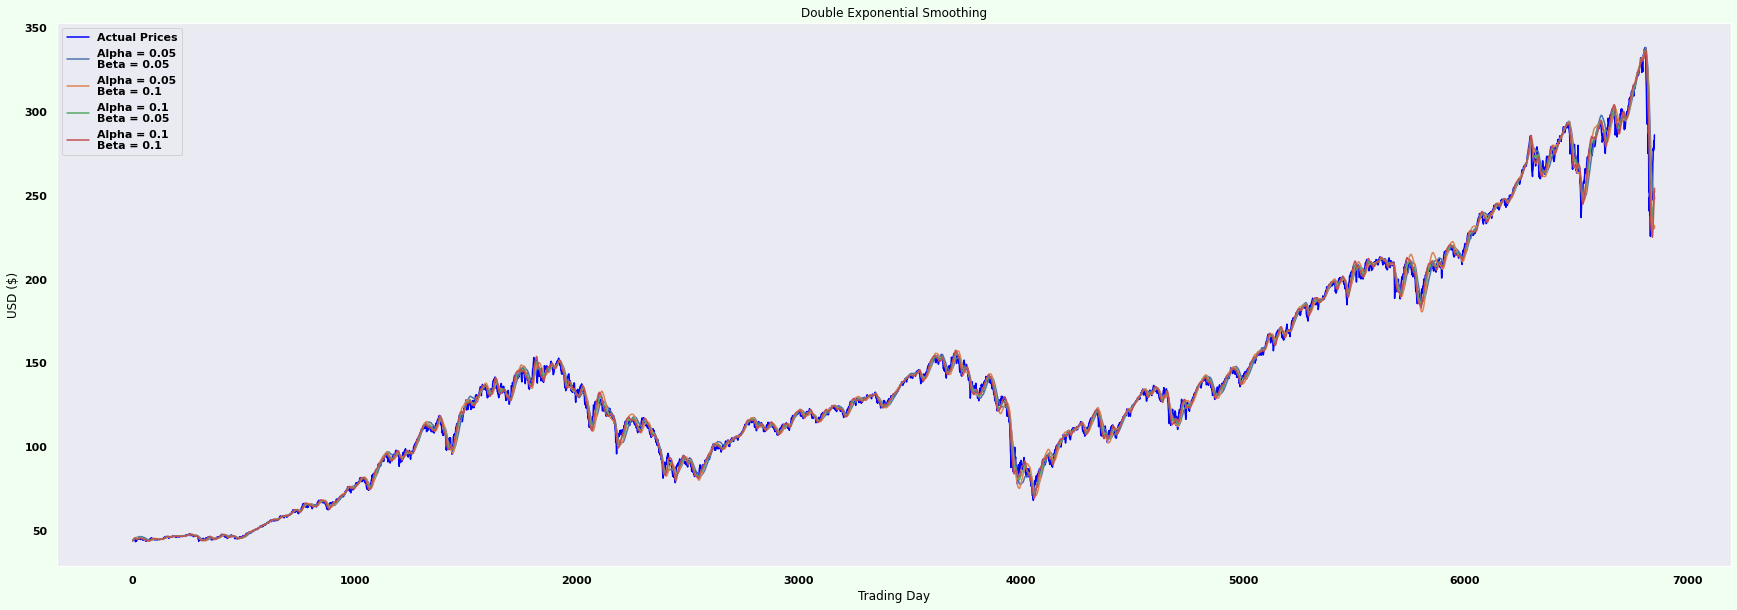

In [46]:
plt_dexp(data.Average, [.05, .1], [.05, .1])

# **LSTM Model**

Now we see if a neural network is better at performing time-series forecasting that the MAs and Exponential Smoothing methods.

## **Normalize and Split the Dataset**

In [0]:
#Build a Data Set
dataset = data.Average.values # Sampled over Days
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
norm = MinMaxScaler(feature_range=(0, 1))
dataset = norm.fit_transform(dataset)
train_n = int(len(dataset)*0.80)
test_n = len(dataset) - train_n
train, test = dataset[0:train_n,:], dataset[train_n:len(dataset),:]


## **Create Dataset consisting of 'Timesteps' (a Matrix)**

In [0]:
def make_ds(data, look_back):
  x, y = [], []
  for i in range(len(data) - look_back - 1):
    a = data[i:(i + look_back), 0]
    b = data[i + look_back, 0]
    x.append(a); y.append(b)
  return np.array(x), np.array(y)

In [0]:
look_back = 30;
xtrain, ytrain = make_ds(train, look_back)
xtest, ytest = make_ds(test, look_back)

## **Format Dataset to of the following Form:**
      *[Samples, Time Steps, Features]*

In [0]:
# Reshape the Matrices to be of the following form [samples, time steps, features]
xtrain = np.reshape(xtrain, (xtrain.shape[0], 1, xtrain.shape[1]))
xtest = np.reshape(xtest, (xtest.shape[0], 1, xtest.shape[1]))

## **Create LSTM-Sequential Model**

In [70]:
mdl = Sequential()
mdl.add(LSTM(128, input_shape = (xtrain.shape[1], xtrain.shape[2])))
mdl.add(Dropout(0.4))
mdl.add(Dense(1))
mdl.compile(loss = 'mean_squared_error', optimizer = 'adam')

history = mdl.fit(xtrain, ytrain, epochs = 25, batch_size = 300, validation_data=(xtest, ytest), callbacks = [EarlyStopping(monitor='val_loss', patience=10)], verbose = 1, shuffle = False)

mdl.summary()

Train on 5452 samples, validate on 1340 samples
Epoch 1/25
5452/5452 [==============================] - 0s 81us/step - loss: 0.0088 - val_loss: 0.0027
Epoch 2/25
5452/5452 [==============================] - 0s 20us/step - loss: 0.0022 - val_loss: 0.0070
Epoch 3/25
5452/5452 [==============================] - 0s 24us/step - loss: 0.0026 - val_loss: 0.0108
Epoch 4/25
5452/5452 [==============================] - 0s 20us/step - loss: 0.0013 - val_loss: 0.0025
Epoch 5/25
5452/5452 [==============================] - 0s 18us/step - loss: 0.0011 - val_loss: 0.0015
Epoch 6/25
5452/5452 [==============================] - 0s 18us/step - loss: 9.0195e-04 - val_loss: 9.6175e-04
Epoch 7/25
5452/5452 [==============================] - 0s 21us/step - loss: 8.6423e-04 - val_loss: 8.7213e-04
Epoch 8/25
5452/5452 [==============================] - 0s 18us/step - loss: 7.8005e-04 - val_loss: 9.0759e-04
Epoch 9/25
5452/5452 [==============================] - 0s 18us/step - loss: 7.1292e-04 - val_loss: 9.23

## **Predictions**

In [71]:
trainpred = mdl.predict(xtrain)
testpred = mdl.predict(xtest)

trainpred = norm.inverse_transform(trainpred)
ytrain = norm.inverse_transform([ytrain])

testpred = norm.inverse_transform(testpred)
ytest = norm.inverse_transform([ytest])

print("Train Mean Absolute Error: ", mean_absolute_error(ytrain[0], trainpred[:, 0]))
print("Train RMSE: ", np.sqrt(mse(ytrain[0], trainpred[:,0])))
print("Test Mean Absolute Error: ", mean_absolute_error(ytest[0], testpred[:, 0]))
print("Test RMSE: ", np.sqrt(mse(ytest[0], testpred[:,0])))
print("\nTest Accuracy: ", predaccuracy(testpred[:,0], ytest[0]))

Train Mean Absolute Error:  2.436464760334003
Train RMSE:  3.5883762048270538
Test Mean Absolute Error:  4.613408866031847
Test RMSE:  7.291899192124892

Test Accuracy:  [100.90680643 100.56176587 100.10894686 ...  93.58841663  95.31988842
  95.12284803]


## **Visualize Predictions**

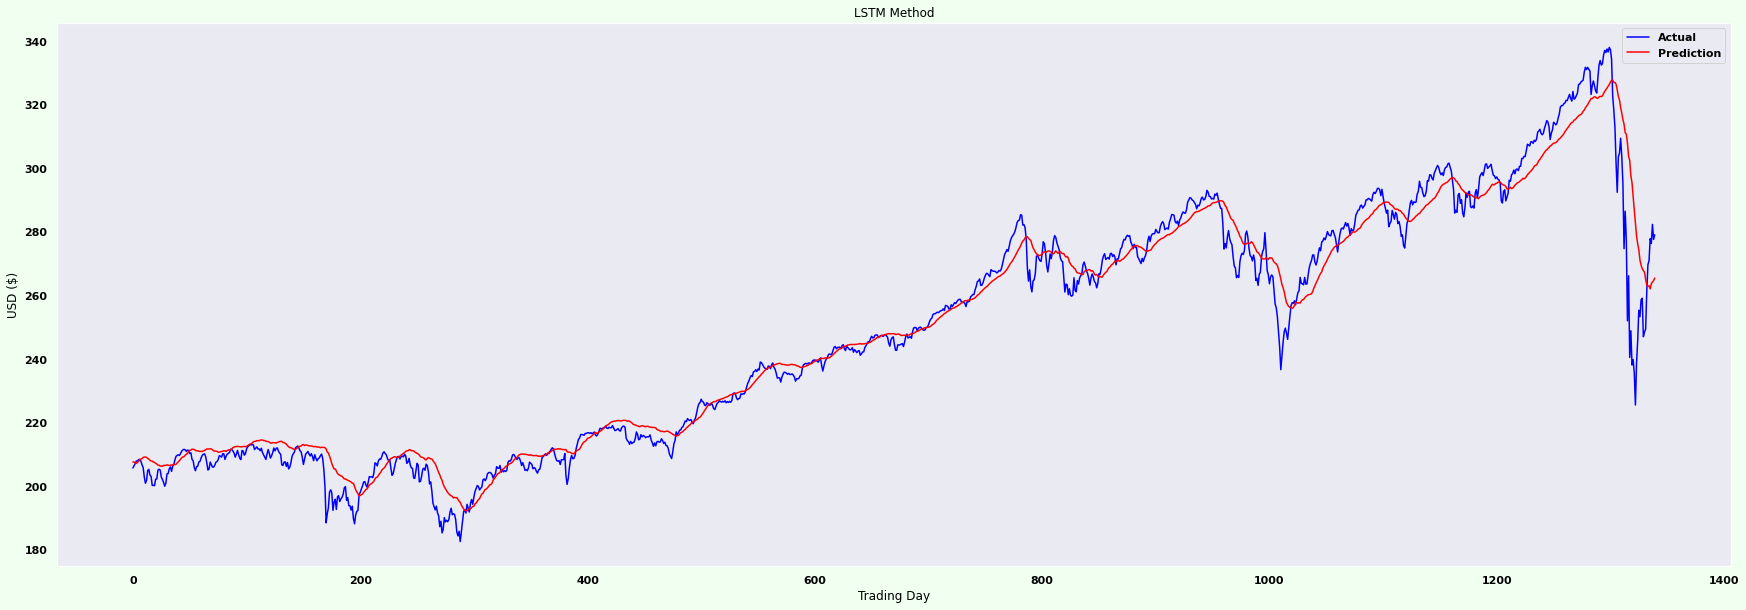

In [72]:
j = len(ytest[0])
n = [i for i in range(j)]
fig = plt.figure(figsize=(30,10), facecolor = 'honeydew')
ax = fig.add_subplot(1,1,1)
ax.plot(n, ytest[0][:j], label = "Actual", c = 'blue')
ax.plot(n, testpred[:,0][:j], c = 'red', label = "Prediction")
ax.set_title("LSTM Method")
ax.set(xlabel = "Trading Day", ylabel  = "USD ($)")
ax.legend(loc = "best")
ax.grid(False)
plt.show()

In [73]:
pa = trendaccuracy(testpred[:,0], ytest[0])
padown, ddays = downtrendaccuracy(testpred[:,0], ytest[0])
paup, udays = uptrendaccuracy(testpred[:,0], ytest[0])

print("The daily-trend accuracy is: {}".format(pa))
print("The down daily-trend accuracy is: {}".format(padown))
print("The up daily-trend accuracy is: {}".format(paup))
print("\nThe total down days is: {}".format(ddays))
print("The total up days is: {}".format(udays))

The daily-trend accuracy is: 52.65123226288275
The down daily-trend accuracy is: 35.40268456375839
The up daily-trend accuracy is: 66.66666666666666

The total down days is: 596
The total up days is: 741


# **Conclusion**

As you can see, the LSTM method is able to predict the changes in Stock Trends over time. Unfortunately, the predictions are delayed in comparison to the actual prices--making this particular model nearly futile. But nonetheless, this was learning exercise and we can still use this particular model to predict trends given recent data. 

To see if our model can be of value to predict daily ups and downs, I caculated the trend accuracy--seeing if the model can identify up or down days accurately. Unfortunately, as you can see that the trend accuracy is a little over 50%. Diving deeper, the model predicts up days much more accurately than down days--nearly twice as much. This can be attributed to tha fact that in recent times, the market has been performing really well. There are more up-days than down-days. The model has become overfitted to this performance in a way.

*If predicitng the stock-market using simple Time Series Forecasting was so easy and effective, everyone would be doing so--and we would have ourselves an effective market where everyone is a winner. Time Series Forecasting cannot be a stand-alone investment strategy, but it can certainly help strengthen our strategies.*